In [5]:
import pandas as pd
fn = r'D:\bus2\ta_20250607132536.csv'
df = pd.read_csv(fn, skiprows=7, encoding='cp949')
df['날짜'] = df['날짜'].str.replace('\t', '', regex=False)
df['날짜'] = pd.to_datetime(df['날짜'])
df['YYYY'] = df['날짜'].dt.year
df['MM'] = df['날짜'].dt.month
df['MMDD'] = df['날짜'].dt.strftime('%m-%d')
df = df[~df['MMDD'].isin(['02-29'])].copy()
df['t_roll'] = df['평균기온(℃)'].rolling(window=9, center=True).mean()


In [13]:
import numpy as np
conditions = [
    (df['YYYY'] >= 1915) & (df['YYYY'] <= 1944),
    (df['YYYY'] >= 1995) & (df['YYYY'] <= 2024)
]
choices = [1, 2]

df['decade_group'] = np.select(conditions, choices, default=0)

In [14]:
data = df[df['decade_group'].isin([1, 2])][['decade_group','MM', 'MMDD', 't_roll']].groupby(['decade_group','MMDD']).mean('MMDD')
data.reset_index(inplace=True)

In [17]:
def str_to_datetime(year, df_series):
    return pd.to_datetime(str(year) + '-' + df_series, format='%Y-%m-%d')

winter_end_2000 =str_to_datetime(2000, data[(data['MM']<=4) & (data['t_roll'] < 5)]
                                 .groupby(['decade_group']).last()['MMDD']) 
winter_end_2001 = str_to_datetime(2001, data[(data['MM']<=4) & (data['t_roll'] < 5)]
                                  .groupby(['decade_group']).last()['MMDD'])

spring_end = str_to_datetime(2000, data[(data['MM']<=8) & (data['t_roll'] < 20)]
                             .groupby(['decade_group']).last()['MMDD'])

summer_end = str_to_datetime(2000, data[data['t_roll']>=20]
                             .groupby('decade_group').last()['MMDD'])

fall_end = str_to_datetime(2000, data[(data['MM'] >= 9) & (data['t_roll']>=5)]
                           .groupby('decade_group').last()['MMDD'])

In [18]:
df_duration = pd.DataFrame({
    'spring': spring_end - winter_end_2000,
    'summer': summer_end - spring_end,
    'fall': fall_end - summer_end,
    'winter': winter_end_2001 - fall_end
})
df_duration.reset_index(inplace=True)

In [ ]:
# 1915-1944
inner_value = [ value.days for value in df_duration.iloc[0].tolist()[1:]]
# 1995-2024
outer_value = [ value.days for value in df_duration.iloc[1].tolist()[1:]]

In [37]:
inner_start = (winter_end_2000.iloc[0] + pd.Timedelta('1D') - pd.to_datetime('2000-01-01') + pd.Timedelta('1D')).days
outer_start = (winter_end_2000.iloc[1] + pd.Timedelta('1D')- pd.to_datetime('2000-01-01') + pd.Timedelta('1D')).days

In [51]:
def plot_donut(ax, value, colors, width, radius, startangle, alpha=0, counterclock=False):
    return ax.pie(value, colors=colors, wedgeprops=dict(width=width, alpha=alpha), radius=radius, startangle=startangle, counterclock=counterclock)

In [ ]:
def write_month_name(ax, radius, fontprop):
    julian_day = [0, 31, 58, 89, 120, 150, 181, 212, 242, 273, 303, 334]
    for idx, day in enumerate(julian_day):
        theta = np.deg2rad(180 - day/365 * 360)
        r = radius
        x = r * np.cos(theta)
        y = r * np.sin(theta)
        rotation = np.rad2deg(theta) - 90
        ax.text(x, y, f'{idx+1}월', ha='center', va='center', rotation=rotation, fontproperties=fontprop)

import unicodedata
def is_korean(ch):
    """한글 여부 판별"""
    return 'HANGUL' in unicodedata.name(ch)

# 한글은 2배 정도의 각도 사용
def get_dtheta(ch, base=0.04):
    if ch == ' ':
        return base * 0.1  # 공백은 작게
    return base * (1.4 if is_korean(ch) else 1)

def write_arc_text(ax, arc_str, radius, deg, fontprop, base=0.04, color='black', alpha=1., flip=False):
    theta = np.deg2rad(deg)
    r = radius
    arc_str = arc_str[::-1] if flip else arc_str
    for s in arc_str:
        x = r * np.cos(theta)
        y = r * np.sin(theta)
        if flip:
            rotation = np.rad2deg(theta) + 90  
        else:
            rotation = np.rad2deg(theta) - 90
        ax.text(x, y, s, ha='center', va='center', rotation=rotation, fontproperties=fontprop, color=color, alpha=alpha)
        theta -= get_dtheta(s, base=base)

        

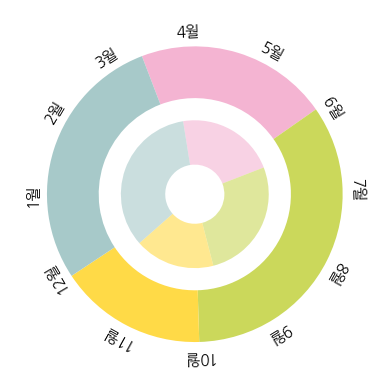

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

colors = [
    (244/255, 180/255, 210/255),  # spring
    (203/255, 216/255, 91/255),   # summer
    (255/255, 218/255, 71/255),   # fall
    (167/255, 201/255, 201/255)   # winter
]

fig, ax = plt.subplots()
fn_font = 'NanumGothic.ttf' # 나눔고딕 폰트 사용
write_month_name(ax, radius=1.1, fontprop=fm.FontProperties(fname=fn_font, size=11))

inner_donut, _ = plot_donut(ax, inner_value, colors=colors, width=0.3, alpha=0.6, 
                            radius=0.5, startangle=-inner_start/365*360 + 180)
outer_donut, _ = plot_donut(ax, outer_value, colors=colors, width=0.35, alpha=1, 
                            radius=1., startangle=-outer_start/365*360 + 180)

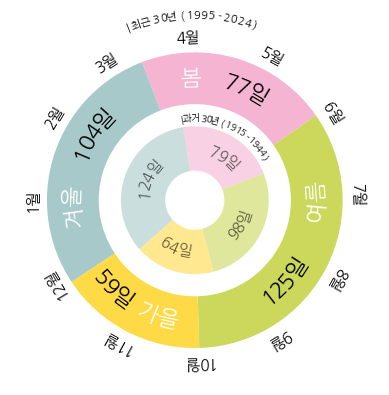

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


colors = [
    (244/255, 180/255, 210/255),  # spring
    (203/255, 216/255, 91/255),   # summer
    (255/255, 218/255, 71/255),   # fall
    (167/255, 201/255, 201/255)   # winter
]


fig, ax = plt.subplots()
fn_font = 'NanumGothic.ttf' # 나눔고딕 폰트 사용

write_month_name(ax, radius=1.1, fontprop=fm.FontProperties(fname=fn_font, size=11))

inner_donut, _ = plot_donut(ax, inner_value, colors=colors, width=0.3, alpha=0.6, radius=0.5, startangle=-inner_start/365*360 + 180)
outer_donut, _ = plot_donut(ax, outer_value, colors=colors, width=0.35, alpha=1, radius=1., startangle=-outer_start/365*360 + 180)

write_arc_text(ax, '|최근 30년 (1995-2024)', 1.25, outer_donut[0].theta2, fm.FontProperties(fname=fn_font, size=8))
write_arc_text(ax, '|과거 30년 (1915-1944)', 0.55, inner_donut[0].theta2, fm.FontProperties(fname=fn_font, size=7), base=0.068)

seasons = ['봄', '여름', '가을', '겨울']
flips = [False, True, True, False]
outer_dthetas = [0.50, 0.55, 0.65, 0.55]
for i in range(4):
    write_arc_text(ax, f'{seasons[i]}', 1 - 0.35/2, 0.25 * outer_donut[i].theta1 + 0.75 * outer_donut[i].theta2 , 
                   fm.FontProperties(fname=fn_font, size=16),  color='white', base=0.12, flip=flips[i])
   
    space = '    ' if seasons[i] in  ['봄', '겨울'] else ''
    write_arc_text(ax, f'{outer_value[i]}{space}일', 1 - 0.35/2, outer_dthetas[i] * outer_donut[i].theta1 +(1- outer_dthetas[i]) * outer_donut[i].theta2 , 
                   fm.FontProperties(fname=fn_font, size=16),  color='black', base=0.1, flip=flips[i])
    

    write_arc_text(ax, f'{inner_value[i]}{space}일', 0.35, 0.4 * inner_donut[i].theta1 + 0.6 * inner_donut[i].theta2 , 
                   fm.FontProperties(fname=fn_font, size=11),  color='black', base=0.17, flip=flips[i], alpha=0.6)

